# Python for Data Science

Getting Web Data: Web Scraping and Rest APIs


- Reading large file collections
- Getting tabular data from web pages with ``pandas``
- Scraping data with 
 - BeautifulSoup
 - (Scrapy)
- Some legal aspects of scraping
- Data from REST APIs
- Building your own REST API with flask

# Reading Large File Collections

- Data from large files (or collections thereof) often does not fit in memory
- But computations on such data can be performed in a streaming fashion
- For complex computations libraries that support streaming are useful (e.g. ``pandas.read_csv`` with chunksize arg)
- Plain python also supports lazy evaluations and computations with a small memory footprint
- The general principle is the same, for plain python or libraries

In [1]:
import glob
import os
import itertools

# finds all csv files in data/random_numbers
files = glob.glob(os.path.join("data",'random_numbers','*.csv'))

# return an iterator of lines over all files
lines = itertools.chain(*map(open,files))

def process_line(line):
    return [int(c) * 2 for c in line.split(",")]

# this could be done without a list comprehension (which loads the data in memory), 
# e.g. to store computations immediately in another file
numbers = [process_line(l) for l in lines]
numbers[:5]

[[0], [98], [172], [22], [162]]

# Getting tabular data from web pages with ``pandas``

- Birth statistics from [Berlin data portal](https://daten.berlin.de/datensaetze)
- [https://en.wikipedia.org/wiki/Berlin_population_statistics](https://en.wikipedia.org/wiki/Berlin_population_statistics)


## Birth statistics of Berlin

Birth statistics can be obtained through the [Berlin data portal](https://daten.berlin.de/datensaetze)

E.g. [https://www.berlin.de/daten/liste-der-vornamen-2014/charlottenburg-wilmersdorf.csv](https://www.berlin.de/daten/liste-der-vornamen-2014/charlottenburg-wilmersdorf.csv)

```
vorname;anzahl;geschlecht
Marie;118;w
Sophie;92;w
Charlotte;76;w
Maria;73;w
Maximilian;66;m
Alexander;53;m
Emilia;52;w
```


In [2]:
import pandas as pd
import urllib
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
basedir = os.path.join("data","vornamen")
os.makedirs(basedir, exist_ok=True)

base_url = "https://raw.githubusercontent.com/berlinonline/haeufige-vornamen-berlin/master/data/cleaned/{}/{}.csv"

boroughs = [
"charlottenburg-wilmersdorf",
"friedrichshain-kreuzberg",
"lichtenberg",
"marzahn-hellersdorf",
"mitte",
"neukoelln",
"pankow",
"reinickendorf",
"spandau",
"steglitz-zehlendorf",
"tempelhof-schoeneberg",
"treptow-koepenick"
]

years = range(2012,2019)


In [4]:
# download all name files from Berlin open data portal
all_names = []

for borough in boroughs:
    for year in years:
        url = base_url.format(year, borough)
        filename = os.path.join(basedir, "{}-{}.csv".format(year,borough))
        urllib.request.urlretrieve(url, filename)
        df_vornamen_stadtteil = pd.read_csv(filename,sep=',',error_bad_lines=False)
        df_vornamen_stadtteil['borough'] = borough
        df_vornamen_stadtteil['year'] = year
        all_names.append(df_vornamen_stadtteil)

# concatenate DataFrames
all_names_df = pd.concat(all_names, sort=True)

In [5]:
all_names_df.sample(n=10)

,anzahl,borough,geschlecht,position,vorname,year
3392,1,mitte,m,NaN,Éric,2013
890,2,pankow,m,1.0,Gunnar,2017
247,4,neukoelln,w,NaN,Annabelle,2013
1298,1,lichtenberg,m,NaN,Jannick,2015
2416,1,mitte,m,NaN,Laurenz,2014
2512,1,neukoelln,m,NaN,Torsten,2013
746,2,neukoelln,m,NaN,Nicholas,2016
491,1,reinickendorf,w,NaN,Elizan,2016
2416,1,charlottenburg-wilmersdorf,m,NaN,Maximilian-Zhichengrui,2012
3249,1,mitte,w,1.0,Faizher,2017


# Getting tabular data from Wikipedia

Let's look at [some population data from Wikipedia](https://en.wikipedia.org/wiki/Berlin_population_statistics)


In [6]:
berlin_population = pd.read_html(
    "https://en.wikipedia.org/wiki/Berlin_population_statistics", header=0)
df_berlin_population = berlin_population[0][:11].set_index('Borough')
df_berlin_population

,Population 30 September 2010,Area in km²,Largest Non-German ethnic groups
Borough,,,
Mitte,332100,39.47,"Turks, Arabs, Kurds, many Asians, Africans and..."
Friedrichshain-Kreuzberg,268831,20.16,"Turks, Arabs, African, Kurds, Chinese"
Pankow,368956,103.01,"Poles, Italians, French, Americans, Vietnamese..."
Charlottenburg-Wilmersdorf,320014,64.72,"Turks, Africans, Russians, Arabs, others."
Spandau,225420,91.91,"Turks, Africans, Russians, Arabs, others."
Steglitz-Zehlendorf,293989,102.50,"Poles, Turks, Croats, Serbs, Koreans"
Tempelhof-Schöneberg,335060,53.09,"Turks, Croats, Serbs, Koreans, Africans"
Neukölln,310283,44.93,"Arabs, Turks, Kurds, Russians, Africans, Poles"
Treptow-Köpenick,241335,168.42,"Russians, Poles, Ukrainians, Vietnamese"


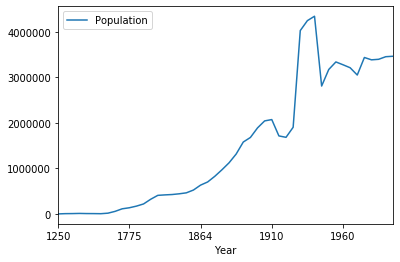

In [7]:
# concatenate all tables on population statistics
overall_population = pd.concat(berlin_population[2:5])
# extract the years
overall_population.Year = overall_population.Year.str.extract('(\d{4})', expand=False)
# set the index to the year column, so plotting is nicer
overall_population = overall_population.set_index("Year")
overall_population.plot();

# Beautiful Soup for Web Scraping

- HTML pages are often not well structured
- [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/)
    - tidies up dirty HTML
    - allows for convenient parsing of HTML


## A Simple Webpage



In [8]:
a_simple_webpage = \
"""<html>
    <head>
    </head>
    <body>
        <p>
            A paragraph
        </p>
        <p id="second_paragraph">
           Another paragraph with a <a href="https://de.wikipedia.org/wiki/Beuth_(Lokomotive)">link</a>
        </p>
    </body>
</html>"""

In [9]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(a_simple_webpage, 'html.parser')

In [10]:
list(soup.children)


[<html>
 <head>
 </head>
 <body>
 <p>
             A paragraph
         </p>
 <p id="second_paragraph">
            Another paragraph with a <a href="https://de.wikipedia.org/wiki/Beuth_(Lokomotive)">link</a>
 </p>
 </body>
 </html>]

## DOM Elements

![HTML DOM Model](figures/DOM-model.png)

### Extracting Texts

In [11]:
paragraphs = soup.find_all('p')
paragraphs

[<p>
             A paragraph
         </p>, <p id="second_paragraph">
            Another paragraph with a <a href="https://de.wikipedia.org/wiki/Beuth_(Lokomotive)">link</a>
 </p>]

In [12]:
[p.get_text().strip() for p in paragraphs]

['A paragraph', 'Another paragraph with a link']

### Extracting Links

In [13]:
links = soup.find_all('a')
links

[<a href="https://de.wikipedia.org/wiki/Beuth_(Lokomotive)">link</a>]

In [14]:
links[0].get('href')

'https://de.wikipedia.org/wiki/Beuth_(Lokomotive)'

### Extracting Arbitrary Elements

In [15]:
[x.get_text().strip() for x in soup.find_all(id="second_paragraph")]

['Another paragraph with a link']

## Example: Downloading Some Data from Wikipedia

Let's find out what was going on with [Christian Peter Beuth](https://de.wikipedia.org/wiki/Peter_Beuth_(Ministerialbeamter)) and [August Borsig](https://de.wikipedia.org/wiki/August_Borsig), or: Why is a steam locomotive and your university named after Beuth? 

In [16]:
import requests # for downloading web pages

url = "https://de.wikipedia.org/wiki/Beuth_(Lokomotive)"

page = requests.get(url)

### Excursion: HTML Status Codes
 
| Code | Type | Meaning |
|------|------|---------|
|1xx | Informational | The request was received, continuing process|
|2xx |Successful | The request was successfully received, understood, and accepted|
|3xx |Redirection| Further action needs to be taken in order to complete the request|
|4xx |Client Error| The request contains bad syntax or cannot be fulfilled|
|5xx |Server Error| The server failed to fulfill an apparently valid request|

In [17]:
page.content[:500]

b'<!DOCTYPE html>\n<html class="client-nojs" lang="de" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>Beuth (Lokomotive) \xe2\x80\x93 Wikipedia</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":[",\\t.",".\\t,"],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","Januar","Februar","M\xc3\xa4rz","April","Mai","Juni","Juli","August","September","Oktober","November","Dezember"],"wgRequestId":"44f862b0-2f12-4e08-a8a0-4d629'

In [18]:
# let beautiful soup parse the html
soup = BeautifulSoup(page.content, 'html.parser')
# find a paragraph in which both beuth (the person, not the steam locomotive) and borsig are mentioned
for p in soup.find_all('p'):
    if 'christian peter wilhelm beuth' in p.get_text().lower() \
        and 'borsig' in p.get_text().lower():
        print(p.get_text())

Die von August Borsig 1844 konstruierte Lokomotive BEUTH mit Werknummer 24 gilt als die erste eigenständig in Deutschland entwickelte Dampflokomotive. Vorher baute Borsig Lokomotiven nach amerikanischen Vorbildern nach. Die Lok gewann ein Wettrennen gegen ein Modell von Stephenson mit etwa zehn Minuten Vorsprung und galt für die folgenden zehn Jahre als Prototyp schneller deutscher Lokomotivkonstruktionen. Eine angetriebene Achse und zwei Laufachsen sowie ein Stehkessel sorgten für vergleichsweise hohe Geschwindigkeiten. Sie bekam ihren Namen nach dem Leiter der preußischen Gewerbeakademie Christian Peter Wilhelm Beuth, der August Borsig prophezeit hatte, dass aus ihm nie etwas werden würde. Ein Nachbau der Lok ist heute im Deutschen Technikmuseum Berlin ausgestellt.



# Crawling Data from Web Pages with [``scrapy``](https://doc.scrapy.org)

**DISLAIMER: Doesn't work with most recent immoscout website**

- Beautiful Soup is great for extracting information from *single webpages*
- Often web sites have multiple pages
- Writing a custom 'spider' to crawl those websites can be tedious
- Dedicated libraries like [``scrapy``](https://doc.scrapy.org) help to scrape data from larger websites efficiently


## Crawling Data First Steps

Find relevant Document Object Model (DOM) elements of website:

- Browse to website and right-click ```Inspect``` (Chrome) or ```Inspect Element``` (Firefox)
- Remember the class / id of elements you are interested in


## Example: Finding a Flat in Berlin

Let's scrape flat data from [immoscout](https://www.immobilienscout24.de/Suche/S-T/Wohnung-Miete/Berlin/Berlin/-/-/-/-/true)

- Find and remember ```class``` of DOM element of each listing
- For each listing, find relevant flat attributes
    - price
    - size
    - location

Then we'll use that information to build our own spider for scrapy



## Example: Finding a Flat in Berlin

Let's scrape flat data from [immoscout](https://www.immobilienscout24.de/Suche/S-T/Wohnung-Miete/Berlin/Berlin/-/-/-/-/true)


### Some Imports and Relevant DOM Elements

```python
from scrapy.spiders import CrawlSpider, Rule
from scrapy.linkextractors.lxmlhtml import LxmlLinkExtractor
from scrapy.selector import Selector
from scrapy.item import Item, Field
from scrapy.http.request import Request

listings_class = "result-list-entry__brand-title-container"
allowed_domain = "immobilienscout24.de"
start_url = "https://www.immobilienscout24.de/Suche/S-T/Wohnung-Miete/Berlin/Berlin/-/-/-/-/true"

attributes = [
    'is24qa-etage',
    'is24qa-flaeche',
    'is24qa-zi',
    'is24qa-bezugsfrei-ab',
    'is24qa-kaltmiete',
    'is24qa-nebenkosten'
]
```

### A Simple Data Model

```python
class ISItem(Item):
    url = Field()

    # allgemein
    is24qa_etage = Field()
    is24qa_flaeche = Field()
    is24qa_zi = Field()
    is24qa_bezugsfrei_ab = Field()

    # kosten
    is24qa_kaltmiete = Field()
    is24qa_nebenkosten = Field()

    lat = Field()
    lng = Field()
    address = Field()
    zip_region_country = Field()
```

### The ```scrapy``` Spider File

```python

class DetailsPageSpider(CrawlSpider):
    name = "is24"
    allowed_domains = [allowed_domain]
    start_urls = [ start_url ]
    rules = (
        # Extract links for next pages
        Rule(LxmlLinkExtractor(
            allow=(),
            restrict_xpaths=(".//*[@id='pager']//div//a")),
            callback='parse_listings',
            follow=True
        ),
    )

    def parse_start_url(self, response):
        return self.parse_listings(response)

    def parse_listings(self, response):
        sel = Selector(response)
        print("listing page", response.url)
        links = sel.xpath(".//*[@class='{}']".format(listing_class))
        for link in links:
            print("="*100)
            link = "https://www.immobilienscout24.de" + link.xpath("@href").extract()[0]
            print(link)
            yield Request(link, callback=self.parse_details)
...
```

### Parsing Single Listings

```python

class DetailsPageSpider(CrawlSpider):
...
    def parse_details(self, response):

        sel = Selector(response)
        print("details", response.url)
        item = ISItem()
        item['url'] = response.url

        for attribute in attributes:
            try:
                item[attribute.replace("-", "_")] = sel.css('.{}::text'.format(attribute)).extract()[0].strip()
            except Exception as e:
                item[attribute.replace("-", "_")] = None
```

### Running the spider:

Type 
```
scrapy runspider is24_spider.py -o mietwohnungen.csv -t csv -L WARN
```
in your command line

In [19]:
import pandas as pd
flats_df = pd.read_csv('data/mietwohnungen.csv')
flats_df['is24qa_kaltmiete'] = flats_df['is24qa_kaltmiete'].str.replace('[.€]','').str.replace(',','.').astype(float)
flats_df['is24qa_flaeche'] = flats_df['is24qa_flaeche'].str.replace(',','.').str.extract('(\d+[.\d+])').astype(float)
flats_df['rent_per_qm'] = flats_df['is24qa_kaltmiete'].astype(float) / flats_df['is24qa_flaeche']
flats_df.sort_values(by='rent_per_qm')[:10]

,address,is24qa_bezugsfrei_ab,is24qa_etage,is24qa_flaeche,is24qa_kaltmiete,is24qa_nebenkosten,is24qa_zi,lat,lng,url,zip_region_country,rent_per_qm
3321,"Chemnitzer Straße 11,",ab sofort,4,482.0,1493.70,NaN,3,"52.50431814189261,",13.581778,https://www.immobilienscout24.de/expose/103502657,"12621 Berlin, Kaulsdorf (Hellersdorf)",3.098963
694,"Sandstraße 64a,",sofort,11,60.0,312.94,NaN,2,"52.51939542525069,",13.171378,https://www.immobilienscout24.de/expose/108497983,"13593 Berlin, Staaken (Spandau)",5.215667
736,"Sandstr. 64b,",sofort,8,58.0,303.39,NaN,2,"52.51958769930993,",13.171705,https://www.immobilienscout24.de/expose/108602455,"13593 Berlin, Staaken (Spandau)",5.230862
2539,"Wiclefstraße 42,",sofort,NaN,130.0,700.00,NaN,1,"52.530806644275785,",13.330809,https://www.immobilienscout24.de/expose/108097130,"10551 Berlin, Tiergarten (Tiergarten)",5.384615
1285,"Marzahner Chaussee 194,",sofort,4,58.0,318.42,NaN,2,"52.52430857597931,",13.534668,https://www.immobilienscout24.de/expose/108665411,"12681 Berlin, Marzahn (Marzahn)",5.490000
2141,"Maulbeerallee 49,",sofort,1 von 6,89.0,490.00,NaN,3,"52.523074993438286,",13.163599,https://www.immobilienscout24.de/expose/108379014,"13593 Berlin, Staaken (Spandau)",5.505618
1491,"Ribnitzer Str 19,",Nach Vereinbarung,10 von 11,70.0,389.78,NaN,3,"52.56937485558645,",13.496459,https://www.immobilienscout24.de/expose/108624980,"13051 Berlin, Neu-Hohenschönhausen (Hohenschön...",5.568286
2008,"Erich-Kästner-Straße 19,",sofort,4 von 5,70.0,391.15,NaN,3,"52.527856075499464,",13.592260,https://www.immobilienscout24.de/expose/108441291,"12619 Berlin, Kaulsdorf (Hellersdorf)",5.587857
2675,"Altenhofer Str. 40,",sofort,8 von 18,61.0,345.00,NaN,2,"52.53585643100882,",13.484577,https://www.immobilienscout24.de/expose/107934956,"13055 Berlin, Alt-Hohenschönhausen (Hohenschön...",5.655738
1254,"Märkische Allee 280,",01.01.2019,18 von 21,62.0,357.73,NaN,3,"52.55813472218006,",13.556239,https://www.immobilienscout24.de/expose/108669708,"12687 Berlin, Marzahn (Marzahn)",5.769839


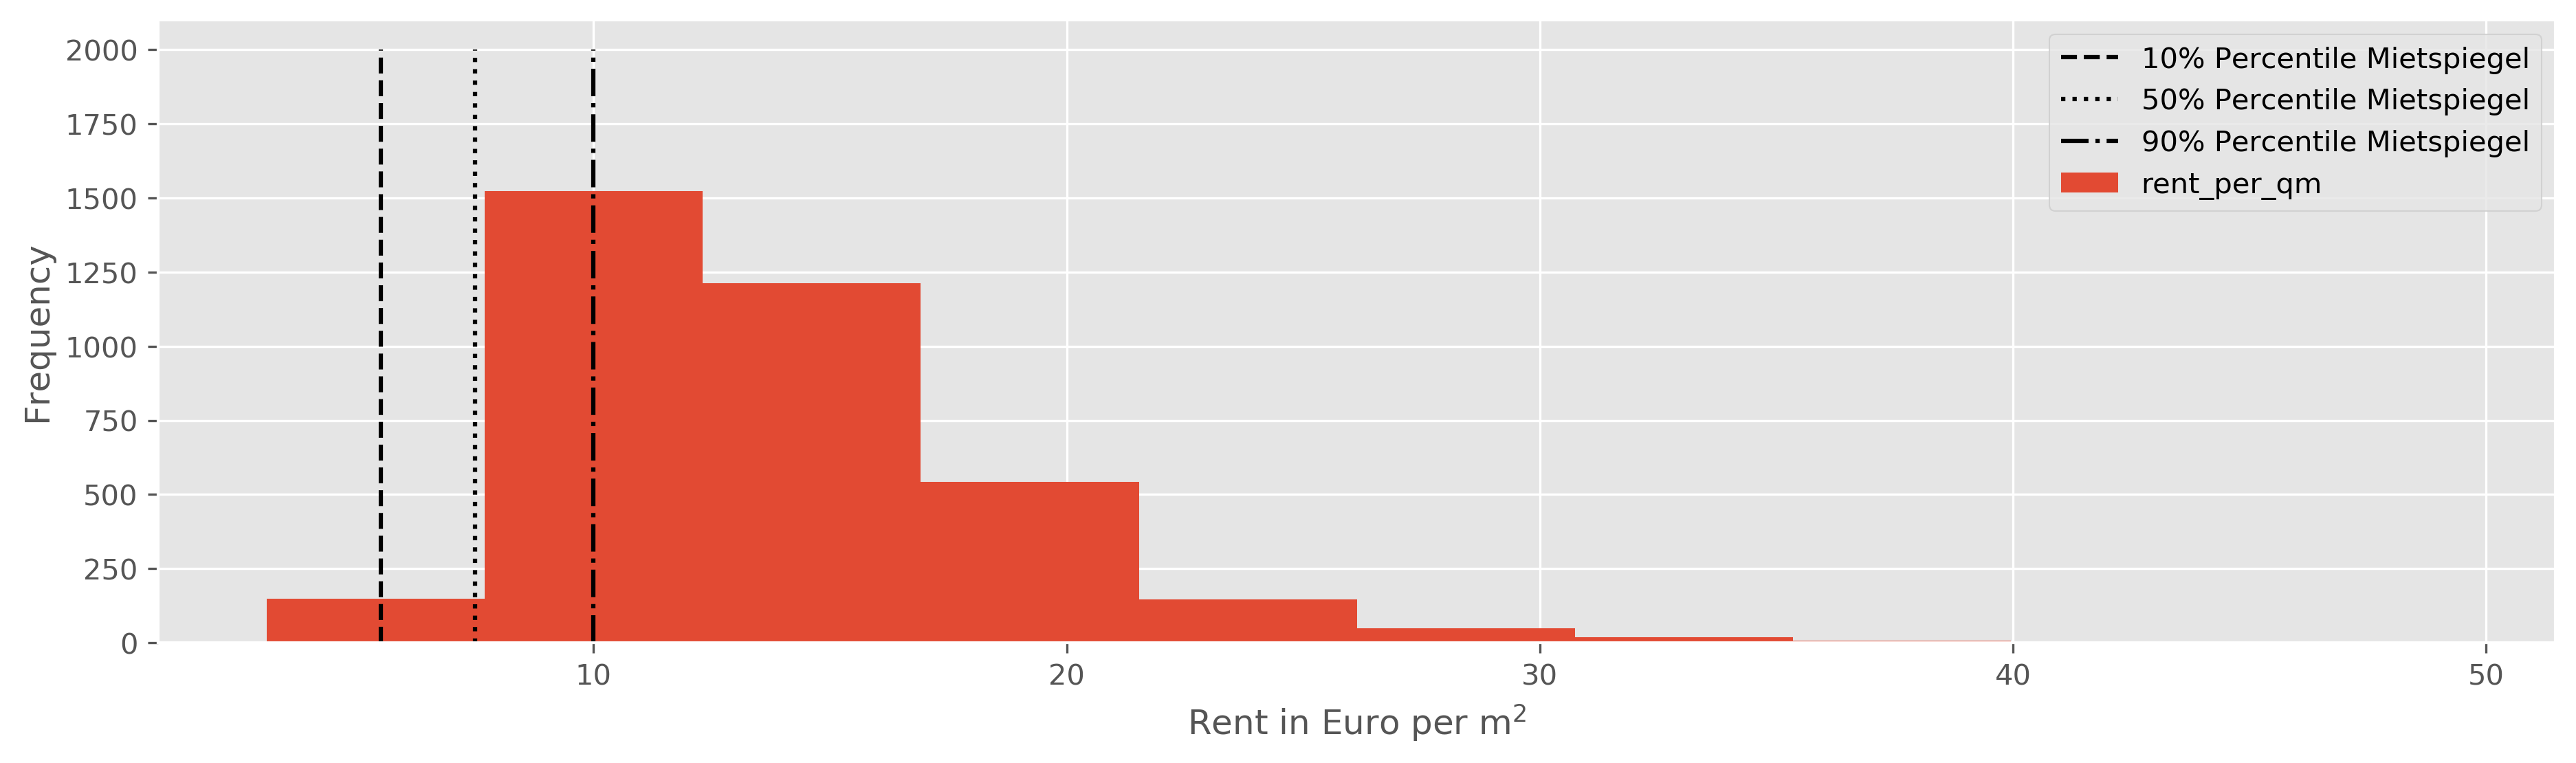

In [20]:
plt.figure(figsize=[15,4],dpi=300)
plt.style.use('ggplot')
flats_df.rent_per_qm[flats_df.rent_per_qm<50].plot.hist(20);
plt.plot([5.5,5.5],[0,2000],'k--',label='10% Percentile Mietspiegel')
plt.plot([7.5,7.5],[0,2000],'k:',label='50% Percentile Mietspiegel')
plt.plot([10,10],[0,2000],'k-.',label='90% Percentile Mietspiegel')
# plt.ylim([0,1000]);
# plt.xlim([3,40]);
plt.legend()
plt.xlabel("Rent in Euro per m$^2$");

## Rent Distribution 2018

![Rent Distribution 2018](figures/mieten_histogram_2018.png)

# Legal Aspects of Scraping

Short version:

If you're doing it for research and if you're not circumventing technical barriers, it's ok. 

See https://www.forschung-und-lehre.de/recht/grenzen-des-web-scrapings-2421

## National vs International Legislation

- The internet is global / international
- Legislation / courts are national
- I will focus on **German Legislation** here

## Database Producer Right

The compilation of data served by website providers is protected by *Database Producer Right*

*Database Producers* (shopping portals, rating portals, …) have exclusive right to:
- Reproduce
- Distribute
- Publicly display

their data

## Implications

Usually web scraping is legal:
(Even if website usage conditions state that it’s not)

* If only minor parts of a DB are downloaded
* BGH (highest German court) decided 10% of a DB are minor
* If technical barriers are not circumvented

## Implications for Researchers

For non-commercial research: 
* ‘Copyright science barrier’:
* 75% of a DB can be downloaded
* But not distributed! 

Since 2018 ‘Barrier for Text und Data Mining (TDM)’
* Researchers can download entire DB to build corpus
* Must not be distributed
* Must be deleted after research project
* Source must be published

# Getting Data From REST APIs

[Representational State Transfer (REST)](https://en.wikipedia.org/wiki/Representational_state_transfer) is a software architectural style for creating web services

RESTful web services allow to access and manipulate web resources through a uniform and predefined set of stateless operations

## Example: Air Quality Data from AQICN

- Air quality is an important topic
- You can query recent worldwide air quality data through an API at [http://aqicn.org/](http://aqicn.org/)
- For example: 
    - [Air Quality Data Berlin](https://aqicn.org/city/germany/berlin)
    - For accessing the API, get an access token
    - then you can query the data for Berlin by requesting (in a browser or in a programmatic fashion)
        ``http://api.waqi.info/feed/berlin/?token=[accessToken]``
    - e.g. [http://api.waqi.info/feed/berlin/?token=my_access_token](http://api.waqi.info/feed/berlin/?token=7672327f1d6675ef5d2d554b63b6175afec9fe77)




In [22]:
import requests

# PLEASE USE YOUR OWN ACCESS TOKEN!
def get_air_quality_data(city, accesstoken='7672327f1d6675ef5d2d554b63b6175afec9fe77'):
    # build request
    url = 'http://api.waqi.info/feed/'+city+'/?token=' + accesstoken
    # get data
    r = requests.get(url, auth=('user', 'pass'))
    # check status code and return data
    if r.status_code == 200:
        data = r.json()
        return data['data']

get_air_quality_data('berlin')

{'aqi': 37,
 'idx': 6132,
 'attributions': [{'url': 'http://www.stadtentwicklung.berlin.de/umwelt/luftqualitaet/',
   'name': 'Berlin Air Quality - (Luftqualität in Berlin)',
   'logo': 'Germany-Berlin.png'},
  {'url': 'https://waqi.info/', 'name': 'World Air Quality Index Project'}],
 'city': {'geo': [52.5200066, 13.404954],
  'name': 'Berlin, Germany',
  'url': 'https://aqicn.org/city/germany/berlin'},
 'dominentpol': 'pm10',
 'iaqi': {'h': {'v': 84},
  'no2': {'v': 17.9},
  'o3': {'v': 4.9},
  'p': {'v': 1026.3},
  'pm10': {'v': 37},
  't': {'v': 6.6},
  'w': {'v': 6},
  'wg': {'v': 12}},
 'time': {'s': '2020-11-11 13:00:00',
  'tz': '+01:00',
  'v': 1605099600,
  'iso': '2020-11-11T13:00:00+01:00'},
 'forecast': {'daily': {'o3': [{'avg': 9,
     'day': '2020-11-09',
     'max': 13,
     'min': 6},
    {'avg': 13, 'day': '2020-11-10', 'max': 17, 'min': 9},
    {'avg': 7, 'day': '2020-11-11', 'max': 14, 'min': 2},
    {'avg': 11, 'day': '2020-11-12', 'max': 23, 'min': 3},
    {'avg':

In [23]:
get_air_quality_data('newyork')

{'aqi': 16,
 'idx': 3309,
 'attributions': [{'url': 'http://www.dec.ny.gov/',
   'name': 'New York State Department of Environmental Conservation (NYSDEC)',
   'logo': 'US-NYDEC.png'},
  {'url': 'http://www.airnow.gov/', 'name': 'Air Now - US EPA'},
  {'url': 'https://waqi.info/', 'name': 'World Air Quality Index Project'}],
 'city': {'geo': [40.7127837, -74.0059413],
  'name': 'New York',
  'url': 'https://aqicn.org/city/newyork'},
 'dominentpol': 'pm25',
 'iaqi': {'h': {'v': 79},
  'p': {'v': 1017.9},
  'pm25': {'v': 16},
  't': {'v': 16.6},
  'w': {'v': 0.3}},
 'time': {'s': '2020-11-11 07:00:00',
  'tz': '-05:00',
  'v': 1605078000,
  'iso': '2020-11-11T07:00:00-05:00'},
 'forecast': {'daily': {'o3': [{'avg': 3,
     'day': '2020-11-09',
     'max': 19,
     'min': 1},
    {'avg': 5, 'day': '2020-11-10', 'max': 15, 'min': 1},
    {'avg': 11, 'day': '2020-11-11', 'max': 17, 'min': 6},
    {'avg': 4, 'day': '2020-11-12', 'max': 19, 'min': 1},
    {'avg': 2, 'day': '2020-11-13', 'max'

In [24]:
get_air_quality_data('seoul')

{'aqi': 104,
 'idx': 5508,
 'attributions': [{'url': 'https://www.airkorea.or.kr/',
   'name': 'South Air Korea Environment Corporation (대기오염실시간공개시스템)',
   'logo': 'SouthKorea-AirKorea.png'},
  {'url': 'http://cleanair.seoul.go.kr/',
   'name': 'Seoul Clean Air Pollution Information (서울특별시 기후대기환경정보)',
   'logo': 'SouthKorea-Seoul.png'},
  {'url': 'http://www.airkorea.or.kr/',
   'name': 'South Air Korea Environment Corporation (대기오염실시간공개시스템)',
   'logo': 'SouthKorea-AirKorea.png'},
  {'url': 'https://waqi.info/', 'name': 'World Air Quality Index Project'}],
 'city': {'geo': [37.566535, 126.9779692],
  'name': 'Seoul (서울)',
  'url': 'https://aqicn.org/city/seoul'},
 'dominentpol': 'pm25',
 'iaqi': {'co': {'v': 8.9},
  'h': {'v': 62},
  'no2': {'v': 71.8},
  'o3': {'v': 1.6},
  'p': {'v': 1032.1},
  'pm10': {'v': 59},
  'pm25': {'v': 104},
  'r': {'v': 0.2},
  'so2': {'v': 7.2},
  't': {'v': 9.6},
  'w': {'v': 1.2},
  'wd': {'v': 22.5}},
 'time': {'s': '2020-11-11 21:00:00',
  'tz': '+09

# Building your own REST API with ``flask``

- [``flask``](http://flask.pocoo.org/) is a microframework for web development in python
- We will build a simple REST API with flask


In [ ]:
#!pip install newspaper3k
#!pip install Flask

In [25]:
import newspaper, json
newspapers = {  
    'zeit': 'http://zeit.de', 
    'tagesspiegel': 'https://www.tagesspiegel.de/'
}

def process_article(article):
    try:
        article.download()
        article.parse()
        return {
                'title': article.title,
                'url': article.url,
        }
    except: 
        pass
    
def process_newspaper(newspaper_url):
    articles = newspaper.build(newspaper_url).articles
    return [process_article(a) for a in articles]

def download_and_save_news(save_path='news.json'):
    news = {n:process_newspaper(url) for n,url in newspapers.items()}
    json.dump(news, open(save_path, 'wt'))

# download_and_save_news()

In [26]:
news = json.load(open('news.json'))
news

{'zeit': [{'title': 'Nachrichten, Hintergründe und Debatten',
   'url': 'http://zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/was-waere-wenn-die-europaeische-union-sich-aufloeste?utm_source=zeit&utm_medium=parkett\n      '},
  {'title': 'Nachrichten, Hintergründe und Debatten',
   'url': 'http://zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/food-start-ups-was-mit-essen?utm_source=zeit&utm_medium=parkett\n      '},
  {'title': 'Nachrichten, Hintergründe und Debatten',
   'url': 'http://www.zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/was-waere-wenn-die-europaeische-union-sich-aufloeste?utm_source=zeit&utm_medium=parkett\n      '},
  {'title': 'Nachrichten, Hintergründe und Debatten',
   'url': 'http://www.zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/food-start-ups-was-mit-esse

## A Minimal Flask API

in ``newsapi.py``:

```python

from flask import Flask, jsonify
import json

app = Flask(__name__)

### API

@app.route('/newsapi/<newspaper_id>')
def get_news_by_newspaper(newspaper_id):
    # return the news of a newspaper
    return jsonify(news.get(newspaper_id, {}))

if __name__ == "__main__":
    port = 5001
    # load some previously downloaded news 
    news = json.load(open('news.json'))
    app.run(host='0.0.0.0', port = port)

```

Now start the server by typing in the commandline

```
python newsapi.py
```

Opening a browser and navigating to ```http://0.0.0.0:5001/newsapi/zeit``` will yield
```
[{"title":"Nachrichten, Hintergr\u00fcnde und Debatten","url":"http://zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/was-waere-wenn-die-europaeische-union-sich-aufloeste?utm_source=zeit&utm_medium=parkett\n      "},{"title":"Nachrichten, Hintergr\u00fcnde und Debatten","url":"http://zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/food-start-ups-was-mit-essen?utm_source=zeit&utm_medium=parkett\n      "},{"title":"Nachrichten, Hintergr\u00fcnde und Debatten","url":"http://www.zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/was-waere-wenn-die-europaeische-union-sich-aufloeste?utm_source=zeit&utm_medium=parkett\n      "},{"title":"Nachrichten, Hintergr\u00fcnde und Debatten","url":"http://www.zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/food-start-ups-was-mit-essen?utm_source=zeit&utm_medium=parkett\n      "},{"title":"Nachrichten, Hintergr\u00fcnde und Debatten","url":"https://www.zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/was-waere-wenn-die-europaeische-union-sich-aufloeste?utm_source=zeit&utm_medium=parkett\n      "},{"title":"Nachrichten, Hintergr\u00fcnde und Debatten","url":"https://www.zeit.de/\n        https:/www.brandeins.de/magazine/brand-eins-wirtschaftsmagazin/2018/lebensmittel/food-start-ups-was-mit-essen?utm_source=zeit&utm_medium=parkett\n      "}]```